In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import random

In [3]:
ds,ds_info=tfds.load('malaria',shuffle_files=True,as_supervised=True,with_info=True)

In [4]:
train_ds=ds["train"]

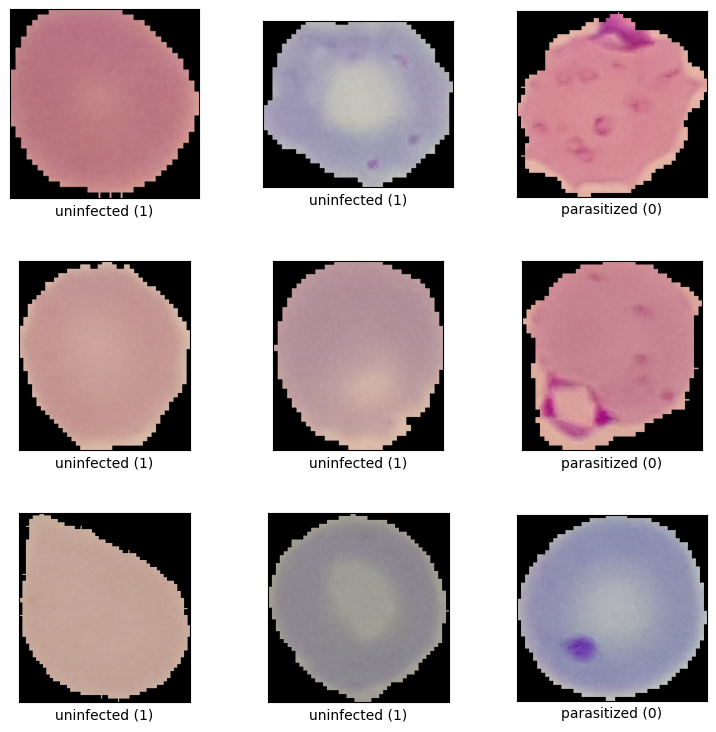

In [5]:
fig=tfds.show_examples(train_ds,ds_info)

In [6]:
NO_OF_PIXELS=128
train_ds=train_ds.map(lambda image,label:(tf.cast(tf.image.resize(image,[NO_OF_PIXELS,NO_OF_PIXELS]),tf.int32),label))

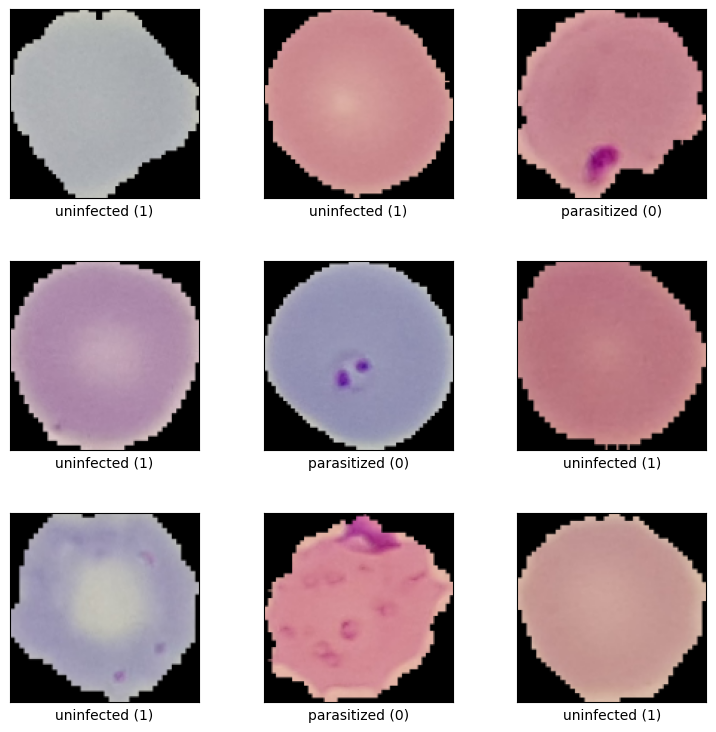

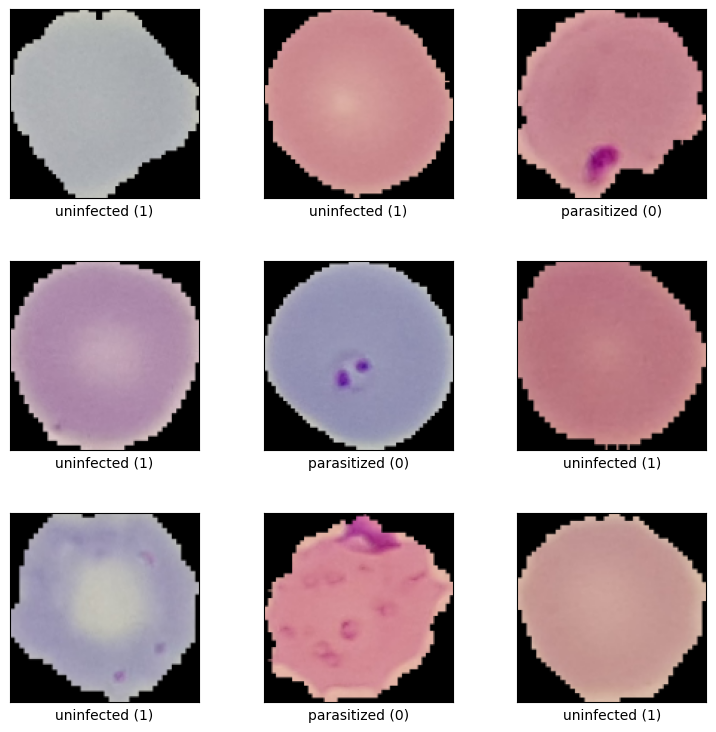

In [7]:
tfds.show_examples(train_ds,ds_info)

In [8]:
for item in train_ds.take(1):
    image,label=item
    print(image.shape)

(128, 128, 3)


In [9]:
data = []
labels = []

for image, label in tfds.as_numpy(train_ds):
    data.append(image)
    labels.append(label)

data = np.array(data)
labels = np.array(labels)

# Split the data into train and test sets
x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

In [10]:
x_train=x_train/255.0
x_test=x_test/255.0
x_valid=x_valid/255.0

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
valid_dataset=tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=100).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [13]:
random.seed(0)
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.RandomFlip("vertical"))
model.add(tf.keras.layers.RandomRotation(0.2))
model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(NO_OF_PIXELS,NO_OF_PIXELS,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(64,(3,3),activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

In [14]:
lr=0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [15]:
epochs=50
model.fit(train_dataset,validation_data=valid_dataset,epochs=epochs,verbose=2)

Epoch 1/50
689/689 - 157s - 227ms/step - accuracy: 0.5618 - loss: 0.6809 - val_accuracy: 0.6350 - val_loss: 0.6634
Epoch 2/50
689/689 - 137s - 199ms/step - accuracy: 0.6380 - loss: 0.6352 - val_accuracy: 0.6948 - val_loss: 0.6195
Epoch 3/50
689/689 - 138s - 201ms/step - accuracy: 0.6990 - loss: 0.5892 - val_accuracy: 0.7515 - val_loss: 0.5655
Epoch 4/50
689/689 - 140s - 203ms/step - accuracy: 0.7654 - loss: 0.5230 - val_accuracy: 0.8469 - val_loss: 0.4680
Epoch 5/50
689/689 - 141s - 205ms/step - accuracy: 0.8457 - loss: 0.4075 - val_accuracy: 0.8966 - val_loss: 0.3500
Epoch 6/50
689/689 - 138s - 200ms/step - accuracy: 0.8837 - loss: 0.3340 - val_accuracy: 0.9118 - val_loss: 0.2954
Epoch 7/50
689/689 - 137s - 199ms/step - accuracy: 0.9040 - loss: 0.2788 - val_accuracy: 0.9100 - val_loss: 0.2345
Epoch 8/50
689/689 - 139s - 202ms/step - accuracy: 0.9128 - loss: 0.2482 - val_accuracy: 0.9205 - val_loss: 0.2363
Epoch 9/50
689/689 - 139s - 202ms/step - accuracy: 0.9184 - loss: 0.2371 - val_a

In [16]:
test_loss, test_acc = model.evaluate(x_test,y_test,verbose=2)
print("The accuracy of the model is:")
print(test_acc*100)

87/87 - 3s - 40ms/step - accuracy: 0.9525 - loss: 0.1509
The accuracy of the model is:
95.24673223495483


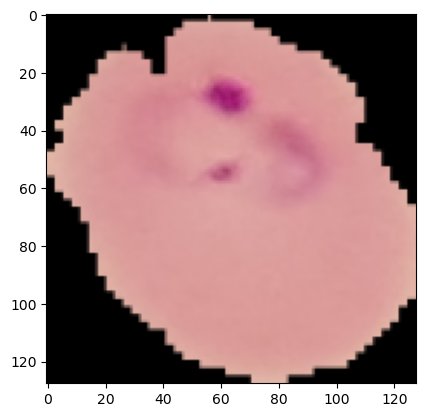

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted probability: [[0.00067698]]
predicted output: parasitized
actual output: parasitized


In [26]:
index=int(random.randrange(0,x_test.shape[0]))
img=x_test[index]
plt.imshow(img)
plt.show()
img=np.asarray(img)
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
print("predicted probability:",pred)
threshold=0.5
if(pred>threshold):
    print("predicted output: uninfected")
else:
    print("predicted output: parasitized")
label=y_test[index]
if(label==1):
    print("actual output: uninfected")
else:
    print("actual output: parasitized")